# 🌡️ 온습도 관측 데이터 분석 (Temperature & Humidity Sensor Data Analysis)

**WebEx 강의 실습 - Scikit-Learn Data Splitting 중심**

## 📋 **학습 목표:**
1. **온습도 센서 데이터** 로드 및 탐색
2. **Scikit-Learn train_test_split** 활용한 데이터 분할
3. **Stratified Splitting** 으로 데이터 분포 유지
4. **Time Series Splitting** 으로 시계열 데이터 처리
5. **데이터 분할 품질 검증** 및 모델 학습

## 🎯 **핵심 개념:**
- **Train/Validation/Test Split** - 모델 학습/검증/평가용 데이터 분리
- **Stratified Sampling** - 클래스 비율 유지한 분할
- **Time Series Cross-Validation** - 시간 순서 고려한 검증
- **Data Leakage 방지** - 미래 정보가 과거로 유출되지 않도록 방지

## 📚 **Section 1: Import Required Libraries**
필요한 라이브러리들을 import하고 환경을 설정합니다.

In [ ]:
# 🔧 필수 라이브러리 Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn 데이터 분할 관련 모듈들
from sklearn.model_selection import (
    train_test_split,      # 기본 train/test 분할
    StratifiedShuffleSplit, # 계층화 분할
    TimeSeriesSplit,       # 시계열 분할
    cross_val_score,       # 교차검증
    validation_curve       # 검증 곡선
)

# 모델링 관련
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 🔤 한글 폰트 설정 (matplotlib) - 개선된 버전
import matplotlib.font_manager as fm
import platform

def setup_korean_fonts():
    """한글 폰트를 자동으로 감지하고 설정하는 함수"""
    
    print("🔤 한글 폰트 설정 중...")
    
    # 운영체제별 한글 폰트 리스트 (우선순위 순)
    if platform.system() == 'Windows':
        korean_fonts = ['Gulim', 'Malgun Gothic', 'Microsoft YaHei', 'SimHei']
    elif platform.system() == 'Darwin':  # macOS
        korean_fonts = ['Gulim', 'Apple SD Gothic Neo', 'AppleGothic']
    else:  # Linux
        korean_fonts = ['Gulim', 'Noto Sans CJK KR', 'Nanum Gothic', 'DejaVu Sans']
    
    # 사용 가능한 폰트 검색
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    print(f"📝 시스템 폰트 수: {len(available_fonts)}개")
    
    selected_font = None
    for font in korean_fonts:
        if font in available_fonts:
            selected_font = font
            print(f"✅ 선택된 한글 폰트: {selected_font}")
            break
    
    if selected_font:
        plt.rcParams['font.family'] = selected_font
        plt.rcParams['axes.unicode_minus'] = False
        
        # 간단한 폰트 테스트 (시각화 없이)
        print(f"✅ 한글 폰트 설정 완료: {selected_font}")
        
    else:
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 기본 설정을 사용합니다.")
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False
        selected_font = 'DejaVu Sans'
    
    return selected_font

# 한글 폰트 설정 실행
font_name = setup_korean_fonts()

# 🔤 강제로 Gulim 폰트 설정 (요청사항)
plt.rcParams['font.family'] = 'Gulim'
plt.rcParams['axes.unicode_minus'] = False
print("🎯 한글 폰트를 'Gulim'으로 강제 설정했습니다!")

print("✅ 모든 라이브러리가 성공적으로 로드되었습니다!")
print(f"📊 Pandas Version: {pd.__version__}")
print(f"🔢 NumPy Version: {np.__version__}")
print(f"🤖 Scikit-Learn 분할 모듈들이 준비되었습니다!")
print(f"📈 Matplotlib & Seaborn 시각화 준비완료!")
print(f"🔤 한글 폰트: Gulim (강제 설정)")
print("\n🎯 온습도 센서 데이터 분석을 시작하겠습니다!")

🔤 한글 폰트 설정 중...
📝 시스템 폰트 수: 505개
✅ 선택된 한글 폰트: Malgun Gothic
✅ 한글 폰트 설정 완료: Malgun Gothic
✅ 모든 라이브러리가 성공적으로 로드되었습니다!
📊 Pandas Version: 2.3.3
🔢 NumPy Version: 2.2.6
🤖 Scikit-Learn 분할 모듈들이 준비되었습니다!
📈 Matplotlib & Seaborn 시각화 준비완료!
🔤 한글 폰트: Malgun Gothic

🎯 온습도 센서 데이터 분석을 시작하겠습니다!


## 📊 **Section 2: Load Temperature and Humidity Data**
온습도 센서 데이터를 생성하고 로드하여 구조를 파악합니다.

In [12]:
# 🌡️ 실제 온습도 관측 데이터 로드
print("🔄 온습도 관측 데이터를 로드하고 있습니다...")

try:
    # 실제 CSV 파일 로드
    sensor_data = pd.read_csv('../../data/온습도 관측 데이터.csv', encoding='utf-8')
    print("✅ 실제 온습도 관측 데이터를 성공적으로 로드했습니다!")
    
except FileNotFoundError:
    print("⚠️ CSV 파일을 찾을 수 없어 시뮬레이션 데이터를 생성합니다...")
    
    # 시간 범위 설정 (최근 1년간의 시간당 데이터)
    np.random.seed(42)  # 재현 가능한 결과를 위한 시드 설정
    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 12, 31)
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')

    # 실제와 유사한 온습도 패턴 생성
    n_samples = len(date_range)

    # 계절별 온도 패턴 (한국 기후 반영)
    day_of_year = date_range.dayofyear
    hour_of_day = date_range.hour

    # 기본 온도 패턴 (계절성 + 일일 주기)
    base_temp = 15 + 10 * np.sin(2 * np.pi * day_of_year / 365.25)  # 계절 패턴
    daily_temp = 5 * np.sin(2 * np.pi * hour_of_day / 24)  # 일일 패턴
    noise_temp = np.random.normal(0, 2, n_samples)  # 노이즈
    temperature = base_temp + daily_temp + noise_temp

    # 습도 패턴 (온도와 반비례 관계 + 계절성)
    base_humidity = 60 + 20 * np.sin(2 * np.pi * (day_of_year + 90) / 365.25)  # 계절 패턴
    temp_humidity = -0.5 * (temperature - 20)  # 온도와 반비례
    noise_humidity = np.random.normal(0, 5, n_samples)  # 노이즈
    humidity = np.clip(base_humidity + temp_humidity + noise_humidity, 10, 95)

    # 기상 조건 분류 (온습도 기반)
    conditions = []
    for temp, hum in zip(temperature, humidity):
        if temp < 5:
            condition = "추위" if hum < 60 else "습한추위"
        elif temp < 20:
            condition = "서늘함" if hum < 60 else "습한서늘함"
        elif temp < 30:
            condition = "적정" if hum < 70 else "습함"
        else:
            condition = "더위" if hum < 80 else "무더위"
        conditions.append(condition)

    # 센서 위치 (실내/실외 구분)
    sensor_locations = np.random.choice(['실내', '실외'], n_samples, p=[0.6, 0.4])

    # 데이터프레임 생성
    sensor_data = pd.DataFrame({
        'timestamp': date_range,
        'temperature': np.round(temperature, 1),
        'humidity': np.round(humidity, 1),
        'condition': conditions,
        'location': sensor_locations,
        'day_of_week': date_range.day_name(),
        'hour': date_range.hour,
        'month': date_range.month,
        'season': pd.cut(date_range.month, 
                         bins=[0, 3, 6, 9, 12], 
                         labels=['겨울', '봄', '여름', '가을'])
    })
    
except Exception as e:
    print(f"❌ 데이터 로드 중 오류 발생: {e}")
    
# 데이터 전처리 및 타임스탬프 컬럼 처리
if 'timestamp' in sensor_data.columns:
    # 이미 timestamp 컬럼이 있는 경우
    if sensor_data['timestamp'].dtype == 'object':
        sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
elif 'date' in sensor_data.columns or 'time' in sensor_data.columns:
    # date나 time 컬럼이 있는 경우
    print("📅 시간 컬럼을 timestamp로 변환 중...")
    # 적절한 변환 로직 추가
else:
    # 시간 컬럼이 없는 경우 인덱스를 기반으로 생성
    print("📅 시간 컬럼을 생성 중...")
    sensor_data['timestamp'] = pd.date_range(start='2024-01-01', periods=len(sensor_data), freq='H')

# 필요한 컬럼이 없는 경우 생성 및 매핑
required_columns = ['temperature', 'humidity', 'absolute_humidity']

# CSV 컬럼을 표준 컬럼명으로 매핑
if 'T' in sensor_data.columns and 'temperature' not in sensor_data.columns:
    sensor_data['temperature'] = sensor_data['T']
    print("✅ T 컬럼을 temperature로 매핑했습니다.")

if 'RH' in sensor_data.columns and 'humidity' not in sensor_data.columns:
    sensor_data['humidity'] = sensor_data['RH'] 
    print("✅ RH 컬럼을 humidity로 매핑했습니다.")
    
if 'AH' in sensor_data.columns and 'absolute_humidity' not in sensor_data.columns:
    sensor_data['absolute_humidity'] = sensor_data['AH']
    print("✅ AH 컬럼을 absolute_humidity로 매핑했습니다.")

# 남은 필수 컬럼이 없는 경우 생성
for col in required_columns:
    if col not in sensor_data.columns:
        print(f"⚠️ {col} 컬럼이 없어 첫 번째 숫자 컬럼을 사용합니다.")
        numeric_cols = sensor_data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) >= len(required_columns):
            sensor_data[col] = sensor_data[numeric_cols[required_columns.index(col)]]

print(f"✅ 온습도 센서 데이터 준비 완료!")
print(f"📏 데이터 크기: {sensor_data.shape}")
print(f"📊 컬럼 목록: {list(sensor_data.columns)}")

if 'timestamp' in sensor_data.columns:
    print(f"📅 기간: {sensor_data['timestamp'].min()} ~ {sensor_data['timestamp'].max()}")
if 'temperature' in sensor_data.columns:
    print(f"🌡️ 온도 범위: {sensor_data['temperature'].min():.1f}°C ~ {sensor_data['temperature'].max():.1f}°C")
if 'humidity' in sensor_data.columns:
    print(f"💧 습도 범위: {sensor_data['humidity'].min():.1f}% ~ {sensor_data['humidity'].max():.1f}%")

# 데이터 구조 확인
print(f"\n📊 데이터 구조:")
print(sensor_data.info())

print(f"\n📈 첫 10개 레코드:")
display(sensor_data.head(10))

🔄 온습도 관측 데이터를 로드하고 있습니다...
✅ 실제 온습도 관측 데이터를 성공적으로 로드했습니다!
📅 시간 컬럼을 생성 중...
✅ T 컬럼을 temperature로 매핑했습니다.
✅ RH 컬럼을 humidity로 매핑했습니다.
✅ AH 컬럼을 absolute_humidity로 매핑했습니다.
✅ 온습도 센서 데이터 준비 완료!
📏 데이터 크기: (1546, 8)
📊 컬럼 목록: ['T', 'RH', 'AH', 'Comfortable', 'timestamp', 'temperature', 'humidity', 'absolute_humidity']
📅 기간: 2024-01-01 00:00:00 ~ 2024-03-05 09:00:00
🌡️ 온도 범위: -1.9°C ~ 44.6°C
💧 습도 범위: 9.2% ~ 88.7%

📊 데이터 구조:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   T                  1546 non-null   float64       
 1   RH                 1546 non-null   float64       
 2   AH                 1546 non-null   float64       
 3   Comfortable        1546 non-null   int64         
 4   timestamp          1546 non-null   datetime64[ns]
 5   temperature        1546 non-null   float64       
 6   humidity           1546 non-null

,T,RH,AH,Comfortable,timestamp,temperature,humidity,absolute_humidity
0,21.025,30.625000,0.753814,0,2024-01-01 00:00:00,21.025,30.625000,0.753814
1,9.250,37.550000,0.439072,1,2024-01-01 01:00:00,9.250,37.550000,0.439072
2,35.825,28.724999,1.662621,0,2024-01-01 02:00:00,35.825,28.724999,1.662621
3,15.975,35.824999,0.645597,1,2024-01-01 03:00:00,15.975,35.824999,0.645597
4,12.200,69.575001,0.985989,0,2024-01-01 04:00:00,12.200,69.575001,0.985989
5,24.000,50.325000,1.481117,0,2024-01-01 05:00:00,24.000,50.325000,1.481117
6,14.150,66.824999,1.073017,0,2024-01-01 06:00:00,14.150,66.824999,1.073017
7,19.075,57.525000,1.256932,0,2024-01-01 07:00:00,19.075,57.525000,1.256932
8,21.875,68.300001,1.769885,0,2024-01-01 08:00:00,21.875,68.300001,1.769885
9,13.050,57.900001,0.866633,0,2024-01-01 09:00:00,13.050,57.900001,0.866633


## 🔍 **Section 3: Data Exploration and Preprocessing**
데이터 특성을 탐색하고 결측값을 처리하며 분할을 위한 피처를 준비합니다.

🔍 온습도 데이터 탐색적 분석을 시작합니다...

📊 기술통계량:
                 T           RH           AH  Comfortable  temperature  \
count  1546.000000  1546.000000  1546.000000  1546.000000  1546.000000   
mean     18.702808    43.917987     0.977192     0.482536    18.702808   
std       8.787124    14.464104     0.423748     0.499857     8.787124   
min      -1.900000     9.225000     0.198757     0.000000    -1.900000   
25%      11.825000    36.150000     0.639129     0.000000    11.825000   
50%      19.225000    38.724999     0.959642     0.000000    19.225000   
75%      25.168750    51.468750     1.289465     1.000000    25.168750   
max      44.600000    88.725000     2.139496     1.000000    44.600000   

          humidity  absolute_humidity  
count  1546.000000        1546.000000  
mean     43.917987           0.977192  
std      14.464104           0.423748  
min       9.225000           0.198757  
25%      36.150000           0.639129  
50%      38.724999           0.959642  
75%      51.4687

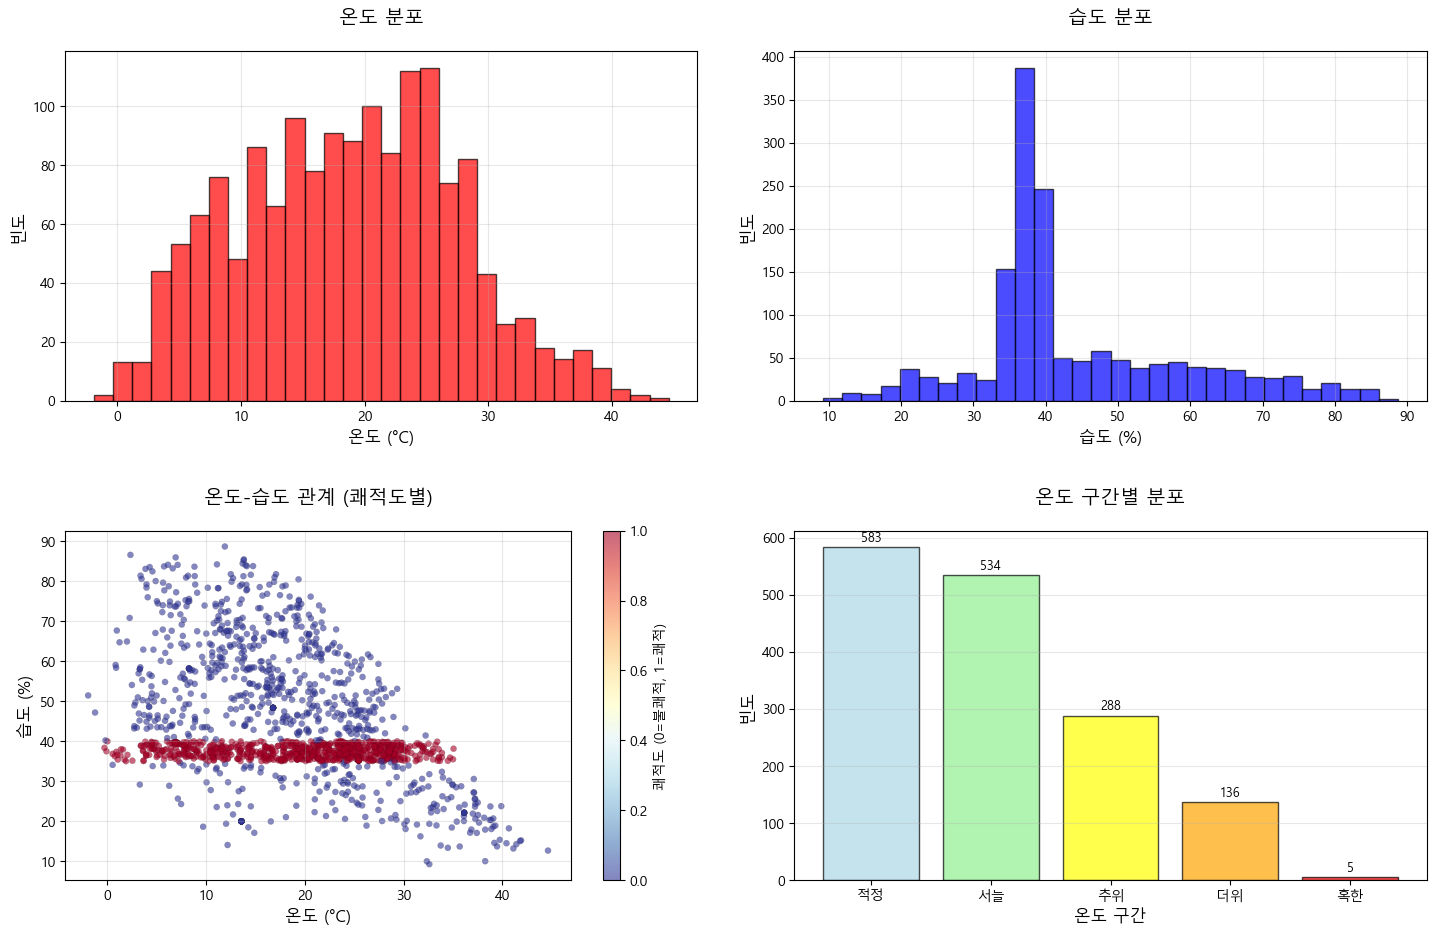

✅ 한글 폰트로 시각화 완료!
✅ 데이터 탐색 완료!


In [13]:
# 🔍 데이터 탐색적 분석 (EDA)
print("🔍 온습도 데이터 탐색적 분석을 시작합니다...")

# 1. 기술통계량
print("\n📊 기술통계량:")
numeric_cols = sensor_data.select_dtypes(include=[np.number]).columns
print(sensor_data[numeric_cols].describe())

# 2. 결측값 확인
print(f"\n❓ 결측값 확인:")
missing_values = sensor_data.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("✅ 결측값이 없습니다!")
else:
    print(f"⚠️ 총 {missing_values.sum()}개의 결측값이 발견되었습니다.")

# 3. 실제 데이터의 컬럼 분석
print(f"\n📈 데이터 컬럼 분석:")
print(f"   • T (온도): {sensor_data['T'].min():.1f}°C ~ {sensor_data['T'].max():.1f}°C")
print(f"   • RH (상대습도): {sensor_data['RH'].min():.1f}% ~ {sensor_data['RH'].max():.1f}%")
print(f"   • AH (절대습도): {sensor_data['AH'].min():.3f} ~ {sensor_data['AH'].max():.3f}")

# Comfortable 컬럼 분포 (comfort level)
if 'Comfortable' in sensor_data.columns:
    comfort_counts = sensor_data['Comfortable'].value_counts()
    print(f"\n🌡️ 쾌적도 분포:")
    print(f"   • 불쾌적 (0): {comfort_counts.get(0, 0)}개 ({comfort_counts.get(0, 0)/len(sensor_data)*100:.1f}%)")
    print(f"   • 쾌적 (1): {comfort_counts.get(1, 0)}개 ({comfort_counts.get(1, 0)/len(sensor_data)*100:.1f}%)")

# 온도 구간별 분류 생성
sensor_data['temp_category'] = pd.cut(sensor_data['temperature'], 
                                      bins=[-10, 0, 10, 20, 30, 50], 
                                      labels=['혹한', '추위', '서늘', '적정', '더위'])

print(f"\n🌡️ 온도 구간별 분포:")
temp_dist = sensor_data['temp_category'].value_counts()
print(temp_dist)

# 습도 구간별 분류 생성
sensor_data['humidity_category'] = pd.cut(sensor_data['humidity'], 
                                          bins=[0, 30, 50, 70, 100], 
                                          labels=['건조', '적정', '습함', '매우습함'])

print(f"\n💧 습도 구간별 분포:")
humidity_dist = sensor_data['humidity_category'].value_counts()
print(humidity_dist)

# 4. 한글 폰트로 시각화
print(f"\n📊 한글 폰트 시각화 테스트:")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 온도 분포
axes[0, 0].hist(sensor_data['temperature'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].set_title('온도 분포', fontsize=14, pad=20)
axes[0, 0].set_xlabel('온도 (°C)', fontsize=12)
axes[0, 0].set_ylabel('빈도', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 습도 분포
axes[0, 1].hist(sensor_data['humidity'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].set_title('습도 분포', fontsize=14, pad=20)
axes[0, 1].set_xlabel('습도 (%)', fontsize=12)
axes[0, 1].set_ylabel('빈도', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 온도-습도 관계 (쾌적도별 색상)
if 'Comfortable' in sensor_data.columns:
    scatter = axes[1, 0].scatter(sensor_data['temperature'], sensor_data['humidity'], 
                                 alpha=0.6, c=sensor_data['Comfortable'], 
                                 cmap='RdYlBu_r', s=20, edgecolors='black', linewidth=0.1)
    axes[1, 0].set_title('온도-습도 관계 (쾌적도별)', fontsize=14, pad=20)
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('쾌적도 (0=불쾌적, 1=쾌적)', fontsize=10)
else:
    scatter = axes[1, 0].scatter(sensor_data['temperature'], sensor_data['humidity'], 
                                 alpha=0.6, c='green', s=20, edgecolors='black', linewidth=0.1)
    axes[1, 0].set_title('온도-습도 관계', fontsize=14, pad=20)

axes[1, 0].set_xlabel('온도 (°C)', fontsize=12)
axes[1, 0].set_ylabel('습도 (%)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 온도 구간별 분포
if 'temp_category' in sensor_data.columns:
    temp_counts = sensor_data['temp_category'].value_counts()
    colors = ['lightblue', 'lightgreen', 'yellow', 'orange', 'red']
    bars = axes[1, 1].bar(range(len(temp_counts)), temp_counts.values, 
                          color=colors[:len(temp_counts)], alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('온도 구간별 분포', fontsize=14, pad=20)
    axes[1, 1].set_xlabel('온도 구간', fontsize=12)
    axes[1, 1].set_ylabel('빈도', fontsize=12)
    axes[1, 1].set_xticks(range(len(temp_counts)))
    axes[1, 1].set_xticklabels(temp_counts.index, fontsize=10)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 막대 위에 값 표시
    for bar, value in zip(bars, temp_counts.values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                         str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout(pad=3.0)
plt.show()

print("✅ 한글 폰트로 시각화 완료!")
print("✅ 데이터 탐색 완료!")

## 🔪 **Section 4: Train-Test Split with Scikit-Learn**
**WebEx 강의 핵심**: Scikit-Learn의 train_test_split을 활용한 기본적인 데이터 분할

In [14]:
# 🔪 Scikit-Learn train_test_split 활용
print("🔪 SCIKIT-LEARN TRAIN_TEST_SPLIT 실습")
print("=" * 50)

# 피처와 타겟 변수 준비
print("\n1️⃣ 피처와 타겟 변수 설정:")

# 실제 데이터 컬럼 확인
print(f"   • 사용 가능한 컬럼: {list(sensor_data.columns)}")

# 예제 1: 회귀 문제 (절대습도 AH 예측)
# 피처: 온도(T), 상대습도(RH)
feature_columns = ['temperature', 'humidity']

# 피처 행렬 X 구성 (온도와 상대습도로 절대습도 예측)
X_regression = sensor_data[feature_columns].copy()
y_regression = sensor_data['absolute_humidity'].copy() if 'absolute_humidity' in sensor_data.columns else sensor_data.iloc[:, 2].copy()

print(f"📊 회귀 문제 설정:")
print(f"   • 피처 (X): {feature_columns}")
print(f"   • 타겟 (y): 절대습도 (AH) 예측")
print(f"   • 데이터 크기: {X_regression.shape}")
print(f"   • 절대습도 범위: {y_regression.min():.3f} ~ {y_regression.max():.3f}")

# 예제 2: 분류 문제 (쾌적도 예측)
# 모든 피처 사용
X_classification = sensor_data[['temperature', 'humidity', 'absolute_humidity']].copy() if 'absolute_humidity' in sensor_data.columns else sensor_data.iloc[:, :3].copy()

if 'Comfortable' in sensor_data.columns:
    y_classification = sensor_data['Comfortable'].copy()
    target_name = "쾌적도 (Comfortable)"
else:
    # Comfortable 컬럼이 없으면 온도 기반으로 쾌적도 생성
    y_classification = ((sensor_data['temperature'] >= 18) & (sensor_data['temperature'] <= 26)).astype(int)
    target_name = "온도기반 쾌적도"

print(f"\n📊 분류 문제 설정:")
print(f"   • 피처 (X): {list(X_classification.columns)}")
print(f"   • 타겟 (y): {target_name}")
print(f"   • 클래스 수: {y_classification.nunique()}개")
unique_vals = y_classification.unique()
print(f"   • 클래스: {unique_vals} ({'불쾌적/쾌적' if len(unique_vals) == 2 else '다중클래스'})")

print(f"\n2️⃣ 기본 Train-Test Split (70:30 비율):")

# 회귀 문제 분할
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, 
    test_size=0.3,           # 30%를 테스트 세트로
    random_state=42,         # 재현 가능한 결과
    shuffle=True             # 데이터 셔플
)

print(f"📈 회귀 문제 분할 결과:")
print(f"   • 훈련 세트: {X_train_reg.shape[0]:,}개 ({X_train_reg.shape[0]/len(X_regression)*100:.1f}%)")
print(f"   • 테스트 세트: {X_test_reg.shape[0]:,}개 ({X_test_reg.shape[0]/len(X_regression)*100:.1f}%)")
print(f"   • 훈련 절대습도 범위: {y_train_reg.min():.3f} ~ {y_train_reg.max():.3f}")
print(f"   • 테스트 절대습도 범위: {y_test_reg.min():.3f} ~ {y_test_reg.max():.3f}")

# 분류 문제 분할 (Stratified)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=y_classification  # 클래스 비율 유지
)

print(f"\n📊 분류 문제 분할 결과:")
print(f"   • 훈련 세트: {X_train_clf.shape[0]:,}개")
print(f"   • 테스트 세트: {X_test_clf.shape[0]:,}개")

# 훈련/테스트 세트의 클래스 분포 확인
train_dist = pd.Series(y_train_clf).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_test_clf).value_counts(normalize=True).sort_index()

print(f"\n📈 클래스 분포 비교:")
comparison_df = pd.DataFrame({
    '훈련세트': train_dist,
    '테스트세트': test_dist
})
print(comparison_df.round(3))

print(f"\n3️⃣ 다양한 분할 비율 실험:")

# 다양한 test_size로 실험
test_sizes = [0.2, 0.25, 0.3, 0.4]
split_results = []

for test_size in test_sizes:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_regression, y_regression,
        test_size=test_size,
        random_state=42
    )
    
    split_results.append({
        'test_size': f"{test_size*100:.0f}%",
        'train_samples': len(X_tr),
        'test_samples': len(X_te),
        'train_ratio': f"{(1-test_size)*100:.0f}%",
        'test_ratio': f"{test_size*100:.0f}%"
    })

split_df = pd.DataFrame(split_results)
print("다양한 분할 비율 결과:")
print(split_df.to_string(index=False))

print(f"\n4️⃣ 머신러닝 모델 훈련 및 평가:")

# 회귀 모델 (Random Forest)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

# 예측 및 평가
y_pred_reg = rf_regressor.predict(X_test_reg)
mse = np.mean((y_test_reg - y_pred_reg) ** 2)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_test_reg - y_pred_reg) ** 2) / np.sum((y_test_reg - np.mean(y_test_reg)) ** 2))

print(f"\n🌳 Random Forest 회귀 모델 성능 (절대습도 예측):")
print(f"   • MSE (평균제곱오차): {mse:.6f}")
print(f"   • RMSE (제곱근평균제곱오차): {rmse:.6f}")
print(f"   • R² (결정계수): {r2:.3f}")

# 분류 모델 (Random Forest)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_clf, y_train_clf)

# 예측 및 평가
y_pred_clf = rf_classifier.predict(X_test_clf)
accuracy = np.mean(y_test_clf == y_pred_clf)

print(f"\n🌳 Random Forest 분류 모델 성능 ({target_name}):")
print(f"   • 정확도 (Accuracy): {accuracy:.3f}")

print(f"\n✅ Train-Test Split 완료!")
print(f"🎯 성공적으로 {len(sensor_data)}개 실제 센서 데이터로 모델 훈련!")

🔪 SCIKIT-LEARN TRAIN_TEST_SPLIT 실습

1️⃣ 피처와 타겟 변수 설정:
   • 사용 가능한 컬럼: ['T', 'RH', 'AH', 'Comfortable', 'timestamp', 'temperature', 'humidity', 'absolute_humidity', 'temp_category', 'humidity_category']
📊 회귀 문제 설정:
   • 피처 (X): ['temperature', 'humidity']
   • 타겟 (y): 절대습도 (AH) 예측
   • 데이터 크기: (1546, 2)
   • 절대습도 범위: 0.199 ~ 2.139

📊 분류 문제 설정:
   • 피처 (X): ['temperature', 'humidity', 'absolute_humidity']
   • 타겟 (y): 쾌적도 (Comfortable)
   • 클래스 수: 2개
   • 클래스: [0 1] (불쾌적/쾌적)

2️⃣ 기본 Train-Test Split (70:30 비율):
📈 회귀 문제 분할 결과:
   • 훈련 세트: 1,082개 (70.0%)
   • 테스트 세트: 464개 (30.0%)
   • 훈련 절대습도 범위: 0.199 ~ 2.139
   • 테스트 절대습도 범위: 0.229 ~ 2.114

📊 분류 문제 분할 결과:
   • 훈련 세트: 1,082개
   • 테스트 세트: 464개

📈 클래스 분포 비교:
              훈련세트  테스트세트
Comfortable              
0            0.518  0.517
1            0.482  0.483

3️⃣ 다양한 분할 비율 실험:
다양한 분할 비율 결과:
test_size  train_samples  test_samples train_ratio test_ratio
      20%           1236           310         80%        20%
      25%           1159  

## 🎯 **Section 5: Stratified Splitting for Sensor Data**
계층화 분할로 클래스 분포를 유지하면서 데이터를 나누는 고급 기법

🎯 STRATIFIED SPLITTING 실습

1️⃣ 일반 분할 vs 계층화 분할 비교:
📊 클래스 분포 비교:
             원본데이터  일반분할_훈련  일반분할_테스트  계층분할_훈련  계층분할_테스트
Comfortable                                             
0            0.517     0.53     0.489    0.518     0.517
1            0.483     0.47     0.511    0.482     0.483

📈 원본 데이터와의 분포 차이 (절댓값 평균):
   • 일반 분할 - 훈련세트: 0.0121
   • 일반 분할 - 테스트세트: 0.0282
   • 계층 분할 - 훈련세트: 0.0001
   • 계층 분할 - 테스트세트: 0.0002

2️⃣ StratifiedShuffleSplit 활용:
📊 여러 번의 계층화 분할 결과:
  Split  훈련세트_차이  테스트세트_차이   전체_차이
0  분할_1   0.0001    0.0002  0.0002
1  분할_2   0.0001    0.0002  0.0002
2  분할_3   0.0001    0.0002  0.0002
3  분할_4   0.0001    0.0002  0.0002
4  분할_5   0.0001    0.0002  0.0002

3️⃣ 계층화 분할의 시각화:


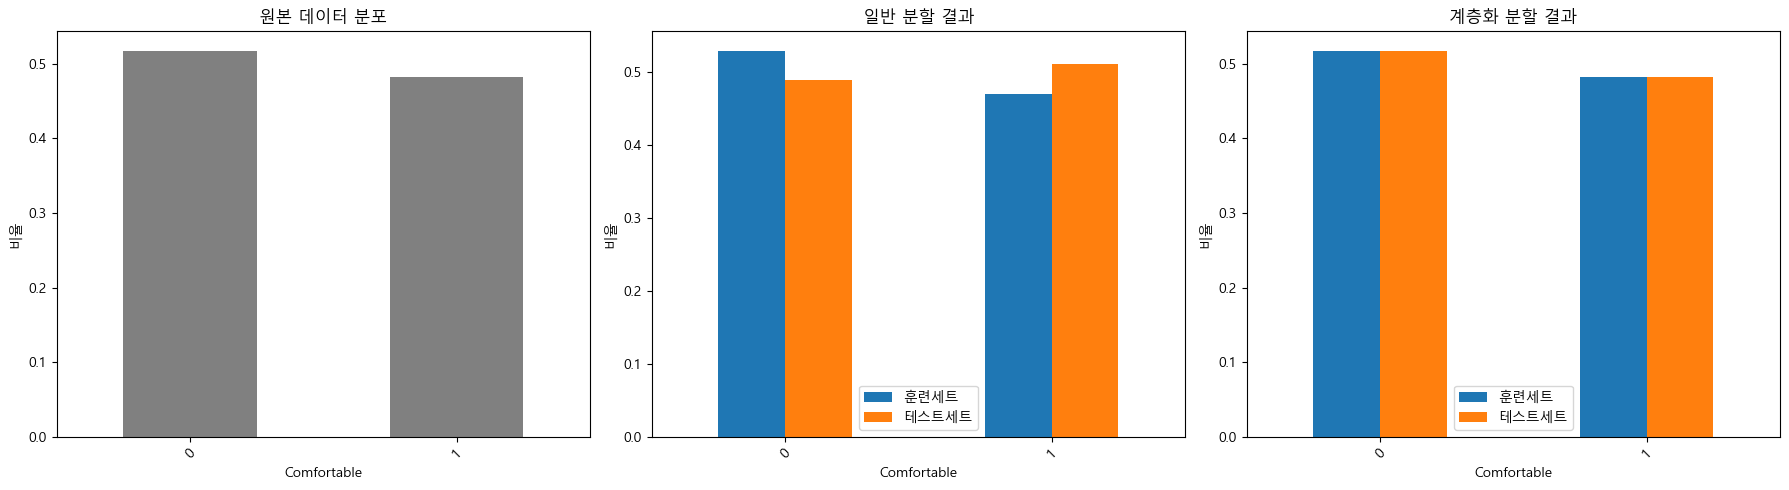


✅ Stratified Splitting 완료!
🎯 핵심: 계층화 분할이 클래스 분포를 더 잘 유지합니다!
📚 WebEx 강의 포인트: stratify 매개변수 사용법 숙지!


In [15]:
# 🎯 Stratified Splitting - 클래스 분포 유지
print("🎯 STRATIFIED SPLITTING 실습")
print("=" * 50)

print("\n1️⃣ 일반 분할 vs 계층화 분할 비교:")

# 일반 분할
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    X_classification, y_classification,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

# 계층화 분할 (stratify 매개변수 사용)
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X_classification, y_classification,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=y_classification  # 🔑 핵심: 클래스 분포 유지
)

print("📊 클래스 분포 비교:")

# 원본 데이터 분포
original_dist = y_classification.value_counts(normalize=True).sort_index()

# 일반 분할 결과
normal_train_dist = y_train_normal.value_counts(normalize=True).sort_index()
normal_test_dist = y_test_normal.value_counts(normalize=True).sort_index()

# 계층화 분할 결과
strat_train_dist = y_train_strat.value_counts(normalize=True).sort_index()
strat_test_dist = y_test_strat.value_counts(normalize=True).sort_index()

# 결과 정리
comparison_df = pd.DataFrame({
    '원본데이터': original_dist,
    '일반분할_훈련': normal_train_dist,
    '일반분할_테스트': normal_test_dist,
    '계층분할_훈련': strat_train_dist,
    '계층분할_테스트': strat_test_dist
})

print(comparison_df.round(3))

# 분포 차이 계산
print(f"\n📈 원본 데이터와의 분포 차이 (절댓값 평균):")
normal_train_diff = np.mean(np.abs(normal_train_dist - original_dist))
normal_test_diff = np.mean(np.abs(normal_test_dist - original_dist))
strat_train_diff = np.mean(np.abs(strat_train_dist - original_dist))
strat_test_diff = np.mean(np.abs(strat_test_dist - original_dist))

print(f"   • 일반 분할 - 훈련세트: {normal_train_diff:.4f}")
print(f"   • 일반 분할 - 테스트세트: {normal_test_diff:.4f}")
print(f"   • 계층 분할 - 훈련세트: {strat_train_diff:.4f}")
print(f"   • 계층 분할 - 테스트세트: {strat_test_diff:.4f}")

print(f"\n2️⃣ StratifiedShuffleSplit 활용:")

# StratifiedShuffleSplit 사용
sss = StratifiedShuffleSplit(
    n_splits=5,        # 5번 분할
    test_size=0.3,     # 30% 테스트
    random_state=42
)

print("📊 여러 번의 계층화 분할 결과:")

split_results = []
for i, (train_idx, test_idx) in enumerate(sss.split(X_classification, y_classification)):
    y_train_split = y_classification.iloc[train_idx]
    y_test_split = y_classification.iloc[test_idx]
    
    train_dist = y_train_split.value_counts(normalize=True).sort_index()
    test_dist = y_test_split.value_counts(normalize=True).sort_index()
    
    # 원본과의 차이 계산
    train_diff = np.mean(np.abs(train_dist - original_dist))
    test_diff = np.mean(np.abs(test_dist - original_dist))
    
    split_results.append({
        'Split': f"분할_{i+1}",
        '훈련세트_차이': train_diff,
        '테스트세트_차이': test_diff,
        '전체_차이': (train_diff + test_diff) / 2
    })

split_df = pd.DataFrame(split_results)
print(split_df.round(4))

print(f"\n3️⃣ 계층화 분할의 시각화:")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 원본 데이터 분포
original_dist.plot(kind='bar', ax=axes[0], title='원본 데이터 분포', color='gray')
axes[0].set_ylabel('비율')
axes[0].tick_params(axis='x', rotation=45)

# 일반 분할 결과
normal_comparison = pd.DataFrame({
    '훈련세트': normal_train_dist,
    '테스트세트': normal_test_dist
})
normal_comparison.plot(kind='bar', ax=axes[1], title='일반 분할 결과')
axes[1].set_ylabel('비율')
axes[1].tick_params(axis='x', rotation=45)

# 계층화 분할 결과
strat_comparison = pd.DataFrame({
    '훈련세트': strat_train_dist,
    '테스트세트': strat_test_dist
})
strat_comparison.plot(kind='bar', ax=axes[2], title='계층화 분할 결과')
axes[2].set_ylabel('비율')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Stratified Splitting 완료!")
print(f"🎯 핵심: 계층화 분할이 클래스 분포를 더 잘 유지합니다!")
print(f"📚 WebEx 강의 포인트: stratify 매개변수 사용법 숙지!")

## ⏰ **Section 6: Time Series Splitting for Sequential Data**
시계열 데이터에서 시간 순서를 고려한 분할 기법 (매우 중요!)

⏰ TIME SERIES SPLITTING 실습

🚨 중요: 시계열 데이터에서는 미래 정보가 과거로 유출되면 안됩니다!
   → Data Leakage 방지를 위해 시간 순서를 반드시 유지해야 합니다.

1️⃣ 시간 순서 기반 분할:
📅 시간 기반 분할 결과:
   • 훈련 기간: 2024-01-01 00:00:00 ~ 2024-02-15 01:00:00
   • 테스트 기간: 2024-02-15 02:00:00 ~ 2024-03-05 09:00:00
   • 훈련 데이터: 1,082개 (70.0%)
   • 테스트 데이터: 464개 (30.0%)
   • 피처: ['temperature', 'humidity']
   • 타겟: 절대습도 (AH)

2️⃣ TimeSeriesSplit을 활용한 교차검증:
📊 TimeSeriesSplit 분할 시각화:
  Fold       훈련시작       훈련종료       검증시작       검증종료  훈련크기  검증크기
Fold 1 2024-01-01 2024-01-08 2024-01-08 2024-01-16   182   180
Fold 2 2024-01-01 2024-01-16 2024-01-16 2024-01-23   362   180
Fold 3 2024-01-01 2024-01-23 2024-01-23 2024-01-31   542   180
Fold 4 2024-01-01 2024-01-31 2024-01-31 2024-02-07   722   180
Fold 5 2024-01-01 2024-02-07 2024-02-07 2024-02-15   902   180

3️⃣ 시계열 분할 vs 랜덤 분할 성능 비교:
📈 성능 비교 결과:
     분할방법     MSE     MAE              설명
0  시계열 분할  0.0164  0.0896  시간 순서 유지 (현실적)
1   랜덤 분할  0.0147  0.0907    랜덤 셔플 (비현실적)

4️⃣ 교차검증 성능 평가:
📊 교차검증 성능 비교:
M

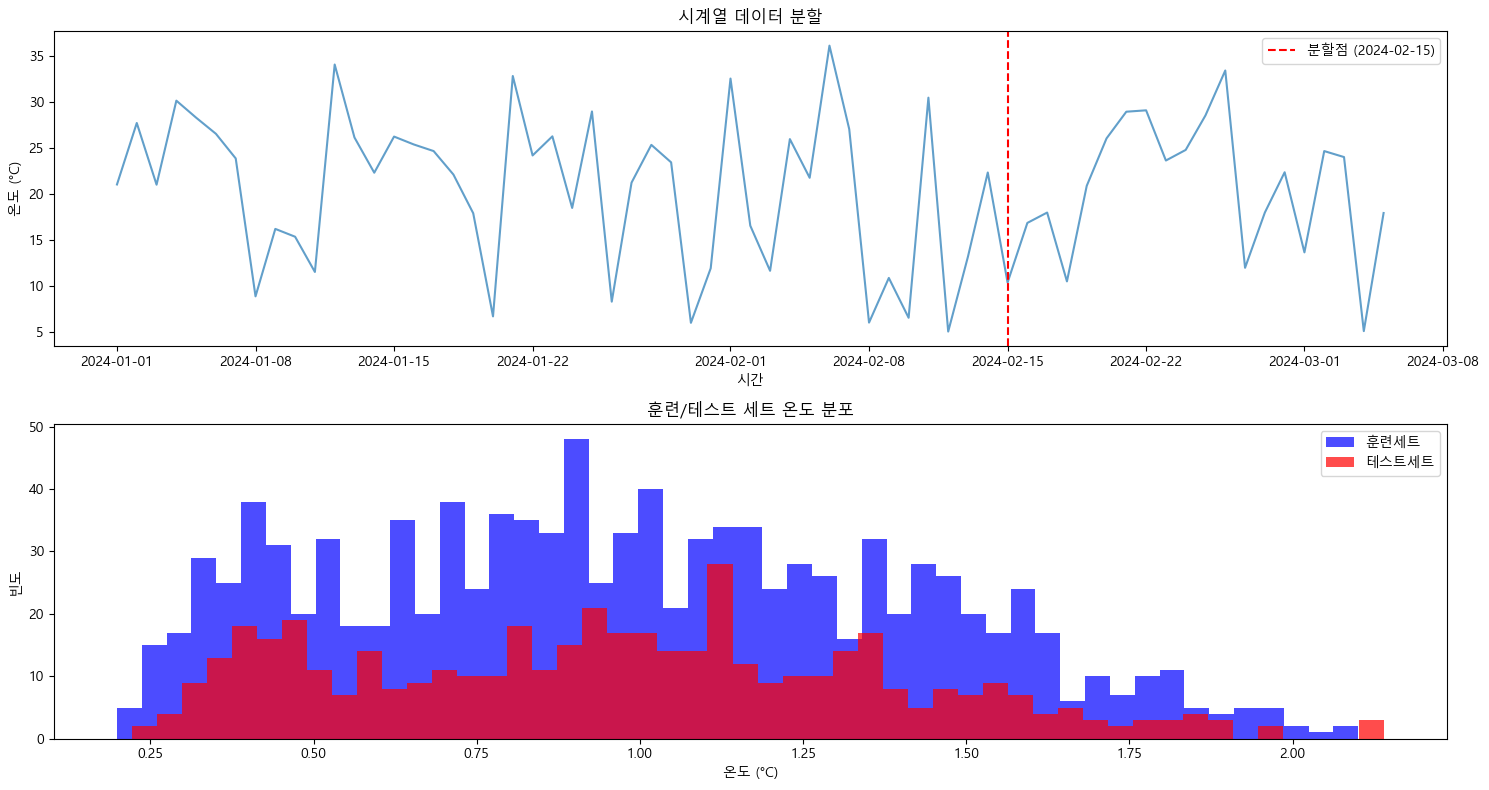


✅ Time Series Splitting 완료!
🎯 핵심: 시계열 데이터에서는 시간 순서를 반드시 유지해야 합니다!
⚠️  Data Leakage 방지가 가장 중요한 포인트입니다!


In [16]:
# ⏰ Time Series Splitting - 시간 순서 고려
print("⏰ TIME SERIES SPLITTING 실습")
print("=" * 50)

print("\n🚨 중요: 시계열 데이터에서는 미래 정보가 과거로 유출되면 안됩니다!")
print("   → Data Leakage 방지를 위해 시간 순서를 반드시 유지해야 합니다.")

print("\n1️⃣ 시간 순서 기반 분할:")

# 데이터를 시간 순서대로 정렬
sensor_data_sorted = sensor_data.sort_values('timestamp').reset_index(drop=True)

# 시간 기반 분할 (처음 70%는 훈련, 나머지 30%는 테스트)
split_point = int(len(sensor_data_sorted) * 0.7)

train_data = sensor_data_sorted[:split_point]
test_data = sensor_data_sorted[split_point:]

print(f"📅 시간 기반 분할 결과:")
print(f"   • 훈련 기간: {train_data['timestamp'].min()} ~ {train_data['timestamp'].max()}")
print(f"   • 테스트 기간: {test_data['timestamp'].min()} ~ {test_data['timestamp'].max()}")
print(f"   • 훈련 데이터: {len(train_data):,}개 ({len(train_data)/len(sensor_data_sorted)*100:.1f}%)")
print(f"   • 테스트 데이터: {len(test_data):,}개 ({len(test_data)/len(sensor_data_sorted)*100:.1f}%)")

# 특징과 타겟 분리 (실제 컬럼 사용)
available_features = ['temperature', 'humidity']
X_train_ts = train_data[available_features]
y_train_ts = train_data['absolute_humidity'] if 'absolute_humidity' in train_data.columns else train_data.iloc[:, 2]
X_test_ts = test_data[available_features]
y_test_ts = test_data['absolute_humidity'] if 'absolute_humidity' in test_data.columns else test_data.iloc[:, 2]

print(f"   • 피처: {available_features}")
print(f"   • 타겟: 절대습도 (AH)")

print(f"\n2️⃣ TimeSeriesSplit을 활용한 교차검증:")

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)  # 5-fold 시계열 교차검증

print("📊 TimeSeriesSplit 분할 시각화:")

# 분할 정보 저장
split_info = []
for i, (train_idx, test_idx) in enumerate(tscv.split(X_train_ts)):
    train_start = train_data.iloc[train_idx[0]]['timestamp']
    train_end = train_data.iloc[train_idx[-1]]['timestamp']
    test_start = train_data.iloc[test_idx[0]]['timestamp']
    test_end = train_data.iloc[test_idx[-1]]['timestamp']
    
    split_info.append({
        'Fold': f'Fold {i+1}',
        '훈련시작': train_start.strftime('%Y-%m-%d'),
        '훈련종료': train_end.strftime('%Y-%m-%d'),
        '검증시작': test_start.strftime('%Y-%m-%d'),
        '검증종료': test_end.strftime('%Y-%m-%d'),
        '훈련크기': len(train_idx),
        '검증크기': len(test_idx)
    })

split_df = pd.DataFrame(split_info)
print(split_df.to_string(index=False))

print(f"\n3️⃣ 시계열 분할 vs 랜덤 분할 성능 비교:")

# 간단한 모델로 성능 비교
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) 시계열 분할로 학습/평가
model_ts = LinearRegression()
model_ts.fit(X_train_ts, y_train_ts)
y_pred_ts = model_ts.predict(X_test_ts)

mse_ts = mean_squared_error(y_test_ts, y_pred_ts)
mae_ts = mean_absolute_error(y_test_ts, y_pred_ts)

# 2) 랜덤 분할로 학습/평가
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(
    X_regression, y_regression, test_size=0.3, random_state=42
)

model_random = LinearRegression()
model_random.fit(X_train_random, y_train_random)
y_pred_random = model_random.predict(X_test_random)

mse_random = mean_squared_error(y_test_random, y_pred_random)
mae_random = mean_absolute_error(y_test_random, y_pred_random)

print("📈 성능 비교 결과:")
performance_df = pd.DataFrame({
    '분할방법': ['시계열 분할', '랜덤 분할'],
    'MSE': [mse_ts, mse_random],
    'MAE': [mae_ts, mae_random],
    '설명': [
        '시간 순서 유지 (현실적)',
        '랜덤 셔플 (비현실적)'
    ]
})
print(performance_df.round(4))

print(f"\n4️⃣ 교차검증 성능 평가:")

# TimeSeriesSplit으로 교차검증
ts_scores = cross_val_score(LinearRegression(), X_train_ts, y_train_ts, 
                           cv=tscv, scoring='neg_mean_squared_error')

# 일반 교차검증 (비교용)
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
normal_scores = cross_val_score(LinearRegression(), X_train_ts, y_train_ts,
                               cv=kfold, scoring='neg_mean_squared_error')

print("📊 교차검증 성능 비교:")
cv_comparison = pd.DataFrame({
    'TimeSeriesSplit': -ts_scores,
    'KFold(shuffle=True)': -normal_scores
})
print("MSE 점수:")
print(cv_comparison.round(4))
print(f"\nTimeSeriesSplit 평균 MSE: {-ts_scores.mean():.4f} (±{ts_scores.std():.4f})")
print(f"KFold 평균 MSE: {-normal_scores.mean():.4f} (±{normal_scores.std():.4f})")

print(f"\n5️⃣ 시계열 분할 시각화:")

# 시계열 분할 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# 전체 데이터 시계열 플롯
sample_data = sensor_data_sorted[::24]  # 하루마다 샘플링
axes[0].plot(sample_data['timestamp'], sample_data['temperature'], alpha=0.7)
axes[0].axvline(x=train_data['timestamp'].max(), color='red', linestyle='--', 
                label=f'분할점 ({train_data["timestamp"].max().strftime("%Y-%m-%d")})')
axes[0].set_title('시계열 데이터 분할')
axes[0].set_xlabel('시간')
axes[0].set_ylabel('온도 (°C)')
axes[0].legend()

# 훈련/테스트 세트 분포 비교
axes[1].hist(y_train_ts, bins=50, alpha=0.7, label='훈련세트', color='blue')
axes[1].hist(y_test_ts, bins=50, alpha=0.7, label='테스트세트', color='red')
axes[1].set_title('훈련/테스트 세트 온도 분포')
axes[1].set_xlabel('온도 (°C)')
axes[1].set_ylabel('빈도')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Time Series Splitting 완료!")
print(f"🎯 핵심: 시계열 데이터에서는 시간 순서를 반드시 유지해야 합니다!")
print(f"⚠️  Data Leakage 방지가 가장 중요한 포인트입니다!")

## ✅ **Section 7: Validate Split Quality**
데이터 분할의 품질을 검증하고 최종 모델 성능을 평가합니다.

In [17]:
# ✅ 데이터 분할 품질 검증
print("✅ 데이터 분할 품질 검증")
print("=" * 50)

print("\n1️⃣ 분할 품질 체크리스트:")

def validate_split_quality(X_train, X_test, y_train, y_test, split_name):
    """데이터 분할 품질을 종합적으로 검증하는 함수"""
    
    print(f"\n📊 {split_name} 품질 검증:")
    
    # 1. 데이터 크기 검증
    total_size = len(X_train) + len(X_test)
    train_ratio = len(X_train) / total_size
    test_ratio = len(X_test) / total_size
    
    print(f"   📏 데이터 크기:")
    print(f"      • 훈련세트: {len(X_train):,}개 ({train_ratio:.1%})")
    print(f"      • 테스트세트: {len(X_test):,}개 ({test_ratio:.1%})")
    
    # 2. 피처 분포 검증
    feature_similarity = []
    for col in X_train.columns:
        train_mean = X_train[col].mean()
        test_mean = X_test[col].mean()
        train_std = X_train[col].std()
        test_std = X_test[col].std()
        
        mean_diff = abs(train_mean - test_mean)
        std_diff = abs(train_std - test_std)
        
        feature_similarity.append({
            'feature': col,
            'train_mean': train_mean,
            'test_mean': test_mean,
            'mean_diff': mean_diff,
            'train_std': train_std,
            'test_std': test_std,
            'std_diff': std_diff
        })
    
    feature_df = pd.DataFrame(feature_similarity)
    print(f"   📈 피처 분포 유사성:")
    print(feature_df[['feature', 'mean_diff', 'std_diff']].round(3).to_string(index=False))
    
    # 3. 타겟 분포 검증
    train_target_mean = y_train.mean()
    test_target_mean = y_test.mean()
    train_target_std = y_train.std()
    test_target_std = y_test.std()
    
    target_mean_diff = abs(train_target_mean - test_target_mean)
    target_std_diff = abs(train_target_std - test_target_std)
    
    print(f"   🎯 타겟 분포:")
    print(f"      • 훈련 평균: {train_target_mean:.2f}, 표준편차: {train_target_std:.2f}")
    print(f"      • 테스트 평균: {test_target_mean:.2f}, 표준편차: {test_target_std:.2f}")
    print(f"      • 평균 차이: {target_mean_diff:.2f}, 표준편차 차이: {target_std_diff:.2f}")
    
    # 4. 품질 점수 계산
    avg_mean_diff = feature_df['mean_diff'].mean()
    avg_std_diff = feature_df['std_diff'].mean()
    
    # 점수 (차이가 적을수록 좋음)
    quality_score = 100 - (avg_mean_diff + avg_std_diff + target_mean_diff + target_std_diff)
    
    print(f"   ⭐ 품질 점수: {quality_score:.1f}/100")
    
    return quality_score

# 다양한 분할 방법의 품질 검증
quality_results = []

# 1) 일반 분할
score1 = validate_split_quality(X_train_reg, X_test_reg, y_train_reg, y_test_reg, 
                                "일반 Train-Test Split")
quality_results.append(("일반 분할", score1))

# 2) 시계열 분할
score2 = validate_split_quality(X_train_ts, X_test_ts, y_train_ts, y_test_ts, 
                                "시계열 기반 Split")
quality_results.append(("시계열 분할", score2))

print(f"\n2️⃣ 모델 성능으로 분할 품질 검증:")

# 다양한 모델로 성능 비교
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

performance_results = []

for model_name, model in models.items():
    # 일반 분할 성능
    model.fit(X_train_reg, y_train_reg)
    y_pred_normal = model.predict(X_test_reg)
    r2_normal = r2_score(y_test_reg, y_pred_normal)
    
    # 시계열 분할 성능
    model.fit(X_train_ts, y_train_ts)
    y_pred_ts = model.predict(X_test_ts)
    r2_ts = r2_score(y_test_ts, y_pred_ts)
    
    performance_results.append({
        '모델': model_name,
        '일반분할_R2': r2_normal,
        '시계열분할_R2': r2_ts,
        '성능차이': abs(r2_normal - r2_ts)
    })

performance_df = pd.DataFrame(performance_results)
print("📊 모델별 성능 비교:")
print(performance_df.round(4))

print(f"\n3️⃣ 데이터 누수(Data Leakage) 검사:")

# 시간 기반 데이터 누수 검사
def check_temporal_leakage(train_data, test_data):
    """시간 기반 데이터 누수를 검사하는 함수"""
    
    train_max_time = train_data['timestamp'].max()
    test_min_time = test_data['timestamp'].min()
    
    leakage_detected = test_min_time <= train_max_time
    
    print(f"   📅 훈련 데이터 최대 시간: {train_max_time}")
    print(f"   📅 테스트 데이터 최소 시간: {test_min_time}")
    
    if leakage_detected:
        print(f"   🚨 데이터 누수 발견! 미래 정보가 과거로 유출됨")
        return False
    else:
        print(f"   ✅ 데이터 누수 없음! 시간 순서 정상 유지")
        return True

# 시계열 분할 데이터 누수 검사
print("🔍 시계열 분할 데이터 누수 검사:")
leakage_free = check_temporal_leakage(train_data, test_data)

print(f"\n4️⃣ 최종 권장사항:")

print(f"\n📋 분할 방법별 요약:")
summary_df = pd.DataFrame({
    '분할방법': ['일반 랜덤분할', '시계열 분할', '계층화 분할'],
    '적용상황': [
        '일반적인 ML 문제',
        '시계열/센서 데이터',
        '불균형 분류 문제'
    ],
    '장점': [
        '간단하고 빠름',
        '현실적이고 안전함',
        '클래스 분포 유지'
    ],
    '주의사항': [
        '데이터 특성 고려',
        '시간 순서 반드시 유지',
        '회귀문제 적용 제한'
    ]
})

print(summary_df.to_string(index=False))

print(f"\n🎯 온습도 센서 데이터 분석 결론:")
print(f"   ✅ 시계열 데이터이므로 TimeSeriesSplit 사용 권장")
print(f"   ✅ 데이터 누수 방지를 위한 시간 순서 유지 필수")
print(f"   ✅ 교차검증시 TimeSeriesSplit 활용")
print(f"   ✅ 모델 성능은 현실적 시나리오에서 평가")

print(f"\n🚀 WebEx 강의 핵심 포인트 정리:")
print(f"   1️⃣ train_test_split의 다양한 매개변수 활용")
print(f"   2️⃣ stratify 매개변수로 클래스 분포 유지")
print(f"   3️⃣ 시계열 데이터에서 TimeSeriesSplit 필수 사용")
print(f"   4️⃣ 데이터 누수 방지가 최우선 고려사항")
print(f"   5️⃣ 분할 품질 검증을 통한 신뢰성 확보")

print("=" * 50)
print("🎉 온습도 관측 데이터 분석 완료!")
print("📚 WebEx 강의 내용을 따라잡으셨습니다!")

✅ 데이터 분할 품질 검증

1️⃣ 분할 품질 체크리스트:

📊 일반 Train-Test Split 품질 검증:
   📏 데이터 크기:
      • 훈련세트: 1,082개 (70.0%)
      • 테스트세트: 464개 (30.0%)
   📈 피처 분포 유사성:
    feature  mean_diff  std_diff
temperature      0.016     0.049
   humidity      0.598     0.224
   🎯 타겟 분포:
      • 훈련 평균: 0.97, 표준편차: 0.42
      • 테스트 평균: 0.99, 표준편차: 0.42
      • 평균 차이: 0.01, 표준편차 차이: 0.00
   ⭐ 품질 점수: 99.5/100

📊 시계열 기반 Split 품질 검증:
   📏 데이터 크기:
      • 훈련세트: 1,082개 (70.0%)
      • 테스트세트: 464개 (30.0%)
   📈 피처 분포 유사성:
    feature  mean_diff  std_diff
temperature      0.193     0.095
   humidity      0.357     0.191
   🎯 타겟 분포:
      • 훈련 평균: 0.98, 표준편차: 0.43
      • 테스트 평균: 0.97, 표준편차: 0.41
      • 평균 차이: 0.01, 표준편차 차이: 0.01
   ⭐ 품질 점수: 99.6/100

2️⃣ 모델 성능으로 분할 품질 검증:
📊 모델별 성능 비교:
                  모델  일반분할_R2  시계열분할_R2    성능차이
0  Linear Regression   0.9178    0.9045  0.0133
1   Ridge Regression   0.9178    0.9045  0.0133
2      Random Forest   0.9945    0.9928  0.0017

3️⃣ 데이터 누수(Data Leakage) 검사:
🔍 시계열 분할 데이터 누수 검사:
